# Libraries and Imports


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from google.colab import drive


drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Kaggle/AB_NYC_2019.csv')
print("Shape:", df.shape)
display(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Understanding the Data

In [3]:
print("\nINFO ")
df.info()

print("\nUNIQUE COUNTS PER COLUMN")
display(df.nunique())

print("\nSAMPLE OF KEY COLUMNS")
cols = ['name','host_name','neighbourhood_group','neighbourhood',]
existing = [c for c in cols if c in df.columns]
display(df[existing].head(10))

print("\nBorough counts:")
print(df['neighbourhood_group'].value_counts(dropna=False))

print("\nRoom type counts:")
print(df['room_type'].value_counts(dropna=False))



INFO 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review              

,0
id,48895
name,47905
host_id,37457
host_name,11452
neighbourhood_group,5
neighbourhood,221
latitude,19048
longitude,14718
room_type,3
price,674



SAMPLE OF KEY COLUMNS


,name,host_name,neighbourhood_group,neighbourhood
0,Clean & quiet apt home by the park,John,Brooklyn,Kensington
1,Skylit Midtown Castle,Jennifer,Manhattan,Midtown
2,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem
3,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill
4,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem
5,Large Cozy 1 BR Apartment In Midtown East,Chris,Manhattan,Murray Hill
6,BlissArtsSpace!,Garon,Brooklyn,Bedford-Stuyvesant
7,Large Furnished Room Near B'way,Shunichi,Manhattan,Hell's Kitchen
8,Cozy Clean Guest Room - Family Apt,MaryEllen,Manhattan,Upper West Side
9,Cute & Cozy Lower East Side 1 bdrm,Ben,Manhattan,Chinatown



Borough counts:
neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

Room type counts:
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64


#EDA before cleaning


MISSING VALUES (count)


,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


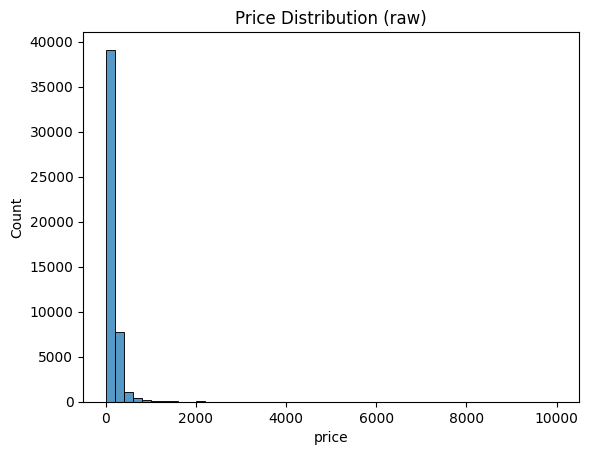

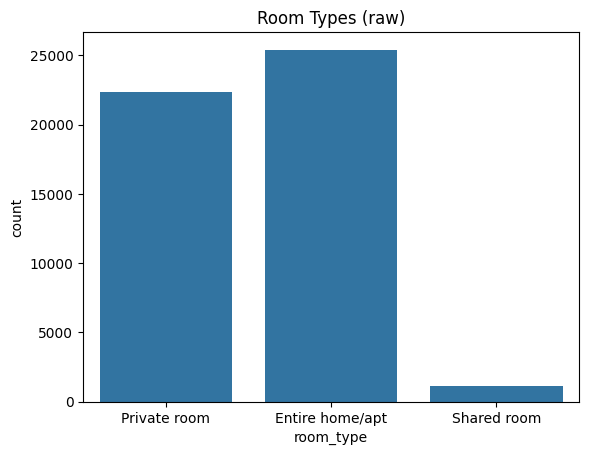

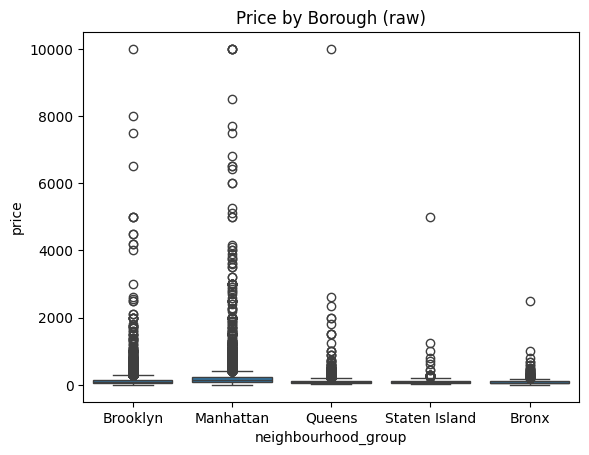

In [4]:
print("\nMISSING VALUES (count)")
display(df.isnull().sum())

#Price distribution
sns.histplot(df['price'], bins=50)
plt.title("Price Distribution (raw)")
plt.show()

#Room type counts
sns.countplot(x='room_type', data=df)
plt.title("Room Types (raw)")
plt.show()

#Price by borough
sns.boxplot(x='neighbourhood_group', y='price', data=df)
plt.title("Price by Borough (raw)")
plt.show()


#Cleaning


In [5]:
#Drop exact duplicates
df.drop_duplicates(inplace=True)

#Convert dates safely (errors -> NaT)
if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

#Fill simple missing values
#If no reviews, set reviews_per_month to 0 (common beginner choice)
if 'reviews_per_month' in df.columns:
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

#Remove obviously bad prices (<= 0)
if 'price' in df.columns:
    df = df[df['price'] > 0]

#Gentle outlier trim on price (cut above 99th percentile)
if 'price' in df.columns:
    p99 = df['price'].quantile(0.99)
    df = df[df['price'] <= p99]

print("Post-clean shape:", df.shape)
display(df.isnull().sum())


Post-clean shape: (48410, 16)


,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


#Visuals after cleaning

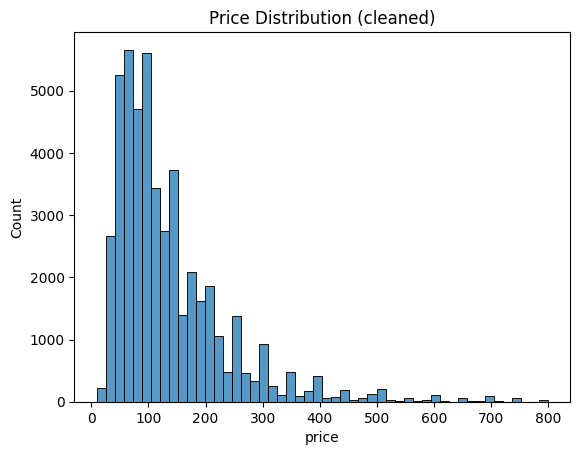

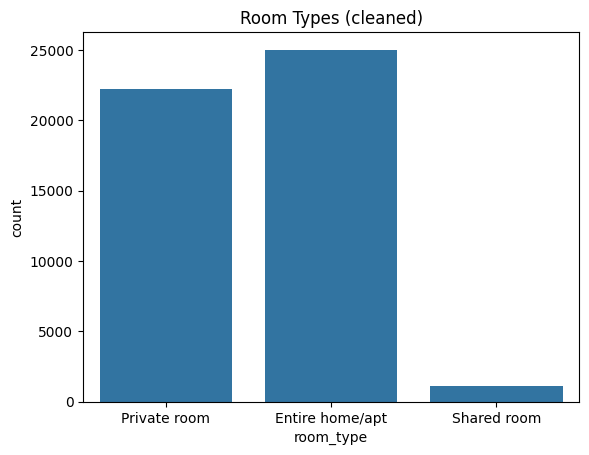

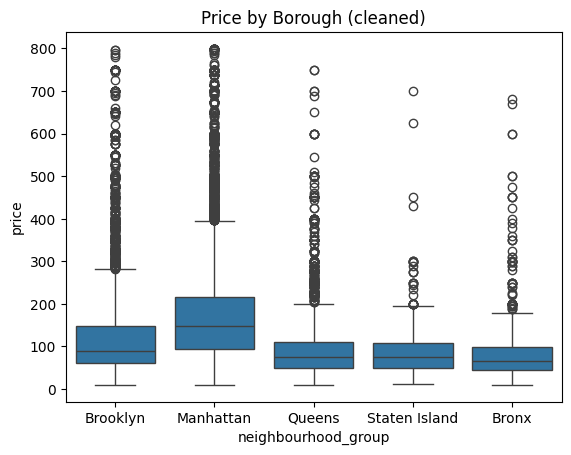


Average price by borough (cleaned):


,price
neighbourhood_group,
Manhattan,172.90
Brooklyn,115.92
Staten Island,94.24
Queens,94.10
Bronx,83.86



Average price by room_type (cleaned):


,price
room_type,
Entire home/apt,189.10
Private room,83.39
Shared room,64.20


In [6]:
sns.histplot(df['price'], bins=50)
plt.title("Price Distribution (cleaned)")
plt.show()

sns.countplot(x='room_type', data=df)
plt.title("Room Types (cleaned)")
plt.show()

sns.boxplot(x='neighbourhood_group', y='price', data=df)
plt.title("Price by Borough (cleaned)")
plt.show()

print("\nAverage price by borough (cleaned):")
display(df.groupby('neighbourhood_group')['price'].mean().round(2).sort_values(ascending=False))

print("\nAverage price by room_type (cleaned):")
display(df.groupby('room_type')['price'].mean().round(2).sort_values(ascending=False))


# Cleaning the Data - Part 2

In [8]:
#Isolate the data we actually want to use
cols = [
    'price',
    'neighbourhood_group',
    'room_type',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

#Keep only those columns that exist in our dataframe
existing = [c for c in cols if c in df.columns]
df_model = df[existing].dropna()
print("\nColumns kept for modeling:")
print(existing)
print("Shape after selecting columns:", df_model.shape)
display(df_model.head())


Columns kept for modeling:
['price', 'neighbourhood_group', 'room_type', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Shape after selecting columns: (48410, 10)


,price,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,149,Brooklyn,Private room,40.64749,-73.97237,1,9,0.21,6,365
1,225,Manhattan,Entire home/apt,40.75362,-73.98377,1,45,0.38,2,355
2,150,Manhattan,Private room,40.80902,-73.94190,3,0,0.00,1,365
3,89,Brooklyn,Entire home/apt,40.68514,-73.95976,1,270,4.64,1,194
4,80,Manhattan,Entire home/apt,40.79851,-73.94399,10,9,0.10,1,0


In [9]:
#Check the data types and missing values again
print("\nData Types")
print(df_model.dtypes)

print("\nMissing Values")
print(df_model.isnull().sum())


Data Types
price                               int64
neighbourhood_group                object
room_type                          object
latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Missing Values
price                             0
neighbourhood_group               0
room_type                         0
latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64


# Define x and y

In [11]:
#Make sure df_model exists
try:
    print("df_model found. Shape:", df_model.shape)
except NameError:
    raise RuntimeError("df_model not found. Run your Week 3 code first to create df_model.")

#Define Features (x) and Target (y)
target = 'price'

#Columns that will be used as features
features = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365'
]

#Create x (features) and y (target)
X = df_model[features]
y = df_model[target]

print("\nFeatures and target defined.")
print("X shape:", X.shape)
print("y shape:", y.shape)

df_model found. Shape: (48410, 10)

Features and target defined.
X shape: (48410, 9)
y shape: (48410,)


# Train/Test Split

In [12]:
from sklearn.model_selection import train_test_split

#Split 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nData split complete:")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

#Preview to confirm split worked
print("\nTraining set preview:")
display(X_train.head())

print("\nTesting set preview:")
display(X_test.head())


Data split complete:
Training set shape: (38728, 9)
Testing set shape: (9682, 9)

Training set preview:


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
12659,Brooklyn,Private room,40.69444,-73.93746,2,2,0.05,1,0
48239,Brooklyn,Private room,40.67331,-73.93212,1,0,0.00,1,58
40976,Manhattan,Private room,40.79959,-73.95924,30,1,1.00,32,346
44138,Manhattan,Entire home/apt,40.76461,-73.98997,3,1,1.00,1,138
8409,Manhattan,Private room,40.73235,-73.98392,3,22,0.46,1,0



Testing set preview:


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
26124,Queens,Entire home/apt,40.76271,-73.92213,3,5,0.23,1,0
16340,Manhattan,Entire home/apt,40.77504,-73.94945,1,95,2.54,2,215
24029,Brooklyn,Private room,40.69224,-73.95819,4,1,0.04,1,0
21538,Bronx,Private room,40.83243,-73.92035,1,11,0.42,3,239
40934,Queens,Private room,40.74001,-73.87629,29,1,0.30,37,31


# First Model: Linear Regression

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

#Identify which columns are categorical (the ones with strings)
cat_cols = ['neighbourhood_group', 'room_type']

#Preprocessing: One-hot encode only the categorical columns
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'   #keep numeric columns as they are
)

#Build pipeline: preprocess → linear regression model
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('linreg', LinearRegression())
])

#Train the model
model.fit(X_train, y_train)
print("\nModel training complete.")

#Make predictions
y_pred = model.predict(X_test)

#Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance (Linear Regression):")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R² Score:", round(r2, 4))

#Show sample predictions
results_preview = pd.DataFrame({
    'Actual Price': y_test[:10].values,
    'Predicted Price': y_pred[:10]
})

print("\nSample Predictions (first 10):")
display(results_preview)

sample = X_test.head(10).copy()
sample['Actual Price'] = y_test[:10].values
sample['Predicted Price'] = y_pred[:10]

display(sample)




Model training complete.

Model Performance (Linear Regression):
MAE: 52.41
RMSE: 83.01
R² Score: 0.3668

Sample Predictions (first 10):


,Actual Price,Predicted Price
0,179,155.836515
1,138,202.370877
2,60,66.419885
3,40,82.262665
4,32,46.409939
5,36,9.635204
6,196,139.736374
7,110,160.151990
8,75,53.050493
9,125,195.619717


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Actual Price,Predicted Price
26124,Queens,Entire home/apt,40.76271,-73.92213,3,5,0.23,1,0,179,155.836515
16340,Manhattan,Entire home/apt,40.77504,-73.94945,1,95,2.54,2,215,138,202.370877
24029,Brooklyn,Private room,40.69224,-73.95819,4,1,0.04,1,0,60,66.419885
21538,Bronx,Private room,40.83243,-73.92035,1,11,0.42,3,239,40,82.262665
40934,Queens,Private room,40.74001,-73.87629,29,1,0.30,37,31,32,46.409939
45302,Bronx,Shared room,40.83717,-73.85738,1,0,0.00,1,71,36,9.635204
22595,Brooklyn,Entire home/apt,40.68707,-73.93490,2,88,3.32,2,9,196,139.736374
28253,Brooklyn,Entire home/apt,40.68165,-73.96006,3,15,0.83,1,3,110,160.151990
35416,Brooklyn,Private room,40.70156,-73.91329,1,14,1.44,1,48,75,53.050493
48323,Brooklyn,Entire home/apt,40.63270,-74.03145,5,0,0.00,1,15,125,195.619717


# KNN Regression

In [14]:
#Second Model: K-Nearest Neighbors (KNN) Regression
#Uses the same X_train, X_test, y_train, y_test, and `preprocess` as before.

from sklearn.neighbors import KNeighborsRegressor

#Build pipeline: preprocess → KNN model
knn_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

#Train the model
knn_model.fit(X_train, y_train)
print("\nKNN model training complete.")

#Make predictions
y_pred_knn = knn_model.predict(X_test)

#Evaluate the model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("\nModel Performance (KNN Regression):")
print("MAE:", round(mae_knn, 2))
print("RMSE:", round(rmse_knn, 2))
print("R² Score:", round(r2_knn, 4))

#Show sample predictions
results_preview_knn = pd.DataFrame({
    'Actual Price': y_test[:10].values,
    'Predicted Price (KNN)': y_pred_knn[:10]
})

print("\nSample Predictions (first 10) – KNN:")
display(results_preview_knn)

sample_knn = X_test.head(10).copy()
sample_knn['Actual Price'] = y_test[:10].values
sample_knn['Predicted Price (KNN)'] = y_pred_knn[:10]

display(sample_knn)



KNN model training complete.

Model Performance (KNN Regression):
MAE: 63.82
RMSE: 95.38
R² Score: 0.164

Sample Predictions (first 10) – KNN:


,Actual Price,Predicted Price (KNN)
0,179,115.6
1,138,140.4
2,60,68.0
3,40,111.8
4,32,34.8
5,36,124.8
6,196,137.0
7,110,220.4
8,75,80.2
9,125,325.0


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Actual Price,Predicted Price (KNN)
26124,Queens,Entire home/apt,40.76271,-73.92213,3,5,0.23,1,0,179,115.6
16340,Manhattan,Entire home/apt,40.77504,-73.94945,1,95,2.54,2,215,138,140.4
24029,Brooklyn,Private room,40.69224,-73.95819,4,1,0.04,1,0,60,68.0
21538,Bronx,Private room,40.83243,-73.92035,1,11,0.42,3,239,40,111.8
40934,Queens,Private room,40.74001,-73.87629,29,1,0.30,37,31,32,34.8
45302,Bronx,Shared room,40.83717,-73.85738,1,0,0.00,1,71,36,124.8
22595,Brooklyn,Entire home/apt,40.68707,-73.93490,2,88,3.32,2,9,196,137.0
28253,Brooklyn,Entire home/apt,40.68165,-73.96006,3,15,0.83,1,3,110,220.4
35416,Brooklyn,Private room,40.70156,-73.91329,1,14,1.44,1,48,75,80.2
48323,Brooklyn,Entire home/apt,40.63270,-74.03145,5,0,0.00,1,15,125,325.0


# Decision Tree Regression

In [15]:
#Third Model: Decision Tree Regression

from sklearn.tree import DecisionTreeRegressor

#Build pipeline: preprocess → Decision Tree model
tree_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('tree', DecisionTreeRegressor(
        max_depth=10,
        random_state=42
    ))
])

#Train the model
tree_model.fit(X_train, y_train)
print("\nDecision Tree model training complete.")

#Make predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("\nModel Performance (Decision Tree Regression):")
print("MAE:", round(mae_tree, 2))
print("RMSE:", round(rmse_tree, 2))
print("R² Score:", round(r2_tree, 4))

#Show sample predictions
results_preview_tree = pd.DataFrame({
    'Actual Price': y_test[:10].values,
    'Predicted Price (Tree)': y_pred_tree[:10]
})

print("\nSample Predictions (first 10) – Decision Tree:")
display(results_preview_tree)

sample_tree = X_test.head(10).copy()
sample_tree['Actual Price'] = y_test[:10].values
sample_tree['Predicted Price (Tree)'] = y_pred_tree[:10]

display(sample_tree)



Decision Tree model training complete.

Model Performance (Decision Tree Regression):
MAE: 46.83
RMSE: 77.41
R² Score: 0.4493

Sample Predictions (first 10) – Decision Tree:


,Actual Price,Predicted Price (Tree)
0,179,130.027149
1,138,187.812236
2,60,61.173780
3,40,56.657971
4,32,34.222222
5,36,77.563786
6,196,130.027149
7,110,132.248292
8,75,64.783489
9,125,107.235955


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Actual Price,Predicted Price (Tree)
26124,Queens,Entire home/apt,40.76271,-73.92213,3,5,0.23,1,0,179,130.027149
16340,Manhattan,Entire home/apt,40.77504,-73.94945,1,95,2.54,2,215,138,187.812236
24029,Brooklyn,Private room,40.69224,-73.95819,4,1,0.04,1,0,60,61.173780
21538,Bronx,Private room,40.83243,-73.92035,1,11,0.42,3,239,40,56.657971
40934,Queens,Private room,40.74001,-73.87629,29,1,0.30,37,31,32,34.222222
45302,Bronx,Shared room,40.83717,-73.85738,1,0,0.00,1,71,36,77.563786
22595,Brooklyn,Entire home/apt,40.68707,-73.93490,2,88,3.32,2,9,196,130.027149
28253,Brooklyn,Entire home/apt,40.68165,-73.96006,3,15,0.83,1,3,110,132.248292
35416,Brooklyn,Private room,40.70156,-73.91329,1,14,1.44,1,48,75,64.783489
48323,Brooklyn,Entire home/apt,40.63270,-74.03145,5,0,0.00,1,15,125,107.235955


# Price Predictor

In [16]:

#Make sure needed objects exist
try:
    df_model, features, model, knn_model, tree_model
except NameError as e:
    raise RuntimeError("Make sure you have run all the cells above (df_model, features, model, knn_model, tree_model).") from e

#Get valid options for the categorical columns
valid_neighbourhoods = sorted(df_model['neighbourhood_group'].dropna().unique())
valid_room_types = sorted(df_model['room_type'].dropna().unique())

#Pre-compute average latitude/longitude per neighbourhood_group
avg_coords = df_model.groupby('neighbourhood_group')[['latitude', 'longitude']].mean()

print("Welcome to the Airbnb Price Predictor")
print("\nValid neighbourhood_group options:")
for n in valid_neighbourhoods:
    print(" -", n)

print("\nValid room_type options:")
for r in valid_room_types:
    print(" -", r)

print("\nType 'quit' at any time for neighbourhood_group to exit.\n")

#Small helper to safely read numeric input
def get_number(prompt, min_value=None, max_value=None):
    while True:
        text = input(prompt).strip()
        try:
            value = float(text)
            if min_value is not None and value < min_value:
                print(f"Please enter a value >= {min_value}.")
                continue
            if max_value is not None and value > max_value:
                print(f"Please enter a value <= {max_value}.")
                continue
            return value
        except ValueError:
            print("Please enter a valid number (e.g. 3 or 3.5).")

#Main loop
while True:
    # --- Categorical inputs ---
    neigh = input("\nEnter neighbourhood_group (or 'quit' to stop): ").strip()
    if neigh.lower() == "quit":
        print("Exiting price predictor. Goodbye!")
        break

    if neigh not in valid_neighbourhoods:
        print("Invalid neighbourhood_group. Please choose from the list shown above.")
        continue

    room = input("Enter room_type: ").strip()
    if room not in valid_room_types:
        print("Invalid room_type. Please choose from the list shown above.")
        continue

    #Use the average latitude/longitude for that neighbourhood
    lat = avg_coords.loc[neigh, 'latitude']
    lon = avg_coords.loc[neigh, 'longitude']

    # --- Numeric inputs ---
    min_nights = get_number("Enter minimum_nights (>= 1): ", min_value=1)
    num_reviews = get_number("Enter number_of_reviews (>= 0): ", min_value=0)
    reviews_pm = get_number("Enter reviews_per_month (>= 0): ", min_value=0)
    host_count = get_number("Enter calculated_host_listings_count (>= 0): ", min_value=0)
    avail_365 = get_number("Enter availability_365 (0–365): ", min_value=0, max_value=365)

    #Build a single-row DataFrame for prediction
    input_data = pd.DataFrame([{
        'neighbourhood_group': neigh,
        'room_type': room,
        'latitude': lat,
        'longitude': lon,
        'minimum_nights': min_nights,
        'number_of_reviews': num_reviews,
        'reviews_per_month': reviews_pm,
        'calculated_host_listings_count': host_count,
        'availability_365': avail_365
    }])

    #Make sure the columns are in the same order as the features we trained on
    input_data = input_data[features]

    #Get predictions from all three models
    pred_lin = model.predict(input_data)[0]
    pred_knn = knn_model.predict(input_data)[0]
    pred_tree = tree_model.predict(input_data)[0]

    #Show results (Decision Tree is the main one)
    print("\n--- Predicted Nightly Price (USD) ---")
    print(f"Decision Tree (best):      ${pred_tree:,.2f}")
    print(f"Linear Regression (middle): ${pred_lin:,.2f}")
    print(f"KNN (worst):                ${pred_knn:,.2f}")


Welcome to the Airbnb Price Predictor

Valid neighbourhood_group options:
 - Bronx
 - Brooklyn
 - Manhattan
 - Queens
 - Staten Island

Valid room_type options:
 - Entire home/apt
 - Private room
 - Shared room

Type 'quit' at any time for neighbourhood_group to exit.


Enter neighbourhood_group (or 'quit' to stop): Bronx
Enter room_type: Private room
Enter minimum_nights (>= 1): 2
Enter number_of_reviews (>= 0): 100
Enter reviews_per_month (>= 0): 3
Enter calculated_host_listings_count (>= 0): 10
Enter availability_365 (0–365): 365

--- Predicted Nightly Price (USD) ---
Decision Tree (best):      $65.81
Linear Regression (middle): $68.24
KNN (worst):                $102.80

Enter neighbourhood_group (or 'quit' to stop): quit
Exiting price predictor. Goodbye!
